Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os


In [ ]:
#unzip
zip_file_name = "/content/drive/MyDrive/human_activity_retrieval_dataset.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('unzipped_images')

In [ ]:
image_folder = "/content/unzipped_images/human_activity_retrieval_dataset/train/"

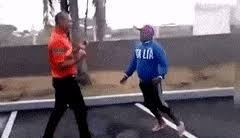

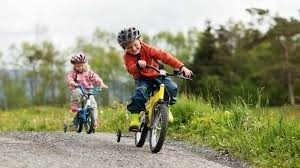

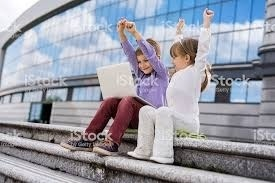

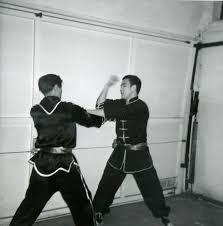

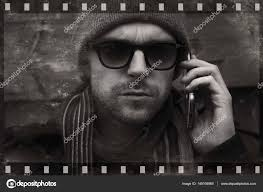

In [ ]:
import cv2
import random
from IPython.display import display, Image

# List all image files in the specified folder
image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Display a random subset of images (e.g., 5 random images)
num_images_to_display = 5
random_images = random.sample(image_files, num_images_to_display)

for image_path in random_images:
    img = cv2.imread(image_path)
    display(Image(data=cv2.imencode('.jpg', img)[1]))


In [ ]:
from PIL import Image
import os

total_width = 0
total_height = 0

# Count the number of images
num_images = 0

for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        with Image.open(os.path.join(image_folder, filename)) as img:
            # Get the width and height of the image
            width, height = img.size
            total_width += width
            total_height += height
            num_images += 1


average_width = total_width / num_images
average_height = total_height / num_images

# Print the results
print(f'Average Width: {average_width}')
print(f'Average Height: {average_height}')


# Imports

In [ ]:
#Imports
import zipfile
import json
import os
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import average_precision_score
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.models import load_model, Model
from google.colab.patches import cv2_imshow
from collections import Counter

# Image processing

In [ ]:

# Load the training dataset labels from the JSON file
with open('/content/unzipped_images/human_activity_retrieval_dataset/train_image_info.json', 'r') as train_file:
    train_labels = json.load(train_file)


In [ ]:

# Get a list of all image filenames
image_filenames = list(train_labels.keys())

# Define the ratio for splitting (e.g., 80% train, 20% test)
train_ratio = 0.8

# Split the filenames into train and test sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=1 - train_ratio, random_state=42)

num_images = len(image_filenames)
num_train_images = len(train_filenames)
num_test_images = len(test_filenames)

print("Total images:", num_images, "Training images:", num_train_images, "Testing images:", num_test_images)


Total images: 11443 Training images: 9154 Testing images: 2289


In [ ]:
# Directory to store train and test data
train_dir = '/content/train_data'
test_dir = '/content/test_data'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [ ]:
# Move images to the train directory
for filename in train_filenames:
    src_path = os.path.join(image_folder, filename)  # Replace with the actual image folder path
    dst_path = os.path.join(train_dir, train_labels[filename], filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

# Move images to the test directory
for filename in test_filenames:
    src_path = os.path.join(image_folder, filename)  # Replace with the actual image folder path
    dst_path = os.path.join(test_dir, train_labels[filename], filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)


In [ ]:
# Create an ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift the width by up to 10%
    height_shift_range=0.1,  # Randomly shift the height by up to 10%
    shear_range=0.1,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom in by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest available value
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
#DATA generators
batch_size = 32  # Adjust as needed

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200,260),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200,260),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9154 images belonging to 15 classes.
Found 2289 images belonging to 15 classes.


In [ ]:
# Get the class labels for train and test data
train_class_labels = train_generator.class_indices
test_class_labels = test_generator.class_indices

# Count the number of images per class in the train set
train_class_counts = Counter(train_generator.classes)

# Count the number of images per class in the test set
test_class_counts = Counter(test_generator.classes)

# Print the distribution of images per class for train set
print("Train Data Distribution:")
for class_label, count in train_class_counts.items():
    class_name = [key for key, value in train_class_labels.items() if value == class_label][0]
    print(f"Class: {class_name}, Count: {count}")

# Print the distribution of images per class for test set
print("\nTest Data Distribution:")
for class_label, count in test_class_counts.items():
    class_name = [key for key, value in test_class_labels.items() if value == class_label][0]
    print(f"Class: {class_name}, Count: {count}")

Train Data Distribution:
Class: calling, Count: 608
Class: clapping, Count: 599
Class: cycling, Count: 607
Class: dancing, Count: 615
Class: drinking, Count: 601
Class: eating, Count: 625
Class: fighting, Count: 615
Class: hugging, Count: 609
Class: laughing, Count: 632
Class: listening_to_music, Count: 600
Class: running, Count: 618
Class: sitting, Count: 601
Class: sleeping, Count: 602
Class: texting, Count: 614
Class: using_laptop, Count: 608

Test Data Distribution:
Class: calling, Count: 155
Class: clapping, Count: 164
Class: cycling, Count: 156
Class: dancing, Count: 145
Class: drinking, Count: 162
Class: eating, Count: 139
Class: fighting, Count: 149
Class: hugging, Count: 153
Class: laughing, Count: 131
Class: listening_to_music, Count: 164
Class: running, Count: 146
Class: sitting, Count: 162
Class: sleeping, Count: 159
Class: texting, Count: 149
Class: using_laptop, Count: 155


# Model

In [ ]:
img_size=(200,260)
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(15, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1,restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('/content/model_weights.h5', save_best_only=True)
callbacks=[rlronp, checkpoint_callback]

# Training

In [ ]:

num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Number of classes (15 in your case)
num_classes = 15

# Train the model
epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=num_test_samples // batch_size,
    callbacks=callbacks
)

Epoch 1/100
286/286 [==============================] - ETA: 0s - loss: 7.8555 - accuracy: 0.4535

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 223s 520ms/step - loss: 7.8555 - accuracy: 0.4535 - val_loss: 7.8390 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/100
286/286 [==============================] - 150s 523ms/step - loss: 4.6713 - accuracy: 0.6814 - val_loss: 4.6245 - val_accuracy: 0.4511 - lr: 0.0010
Epoch 3/100
286/286 [==============================] - 147s 514ms/step - loss: 3.2385 - accuracy: 0.7562 - val_loss: 4.0095 - val_accuracy: 0.3688 - lr: 0.0010
Epoch 4/100
286/286 [==============================] - 147s 511ms/step - loss: 2.3974 - accuracy: 0.7948 - val_loss: 2.6743 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 5/100
286/286 [==============================] - 146s 512ms/step - loss: 1.8239 - accuracy: 0.8277 - val_loss: 2.4937 - val_accuracy: 0.5445 - lr: 0.0010
Epoch 6/100
286/286 [==============================] - 146s 509ms/step - loss: 1.4337 - accuracy: 0.8509 - val_loss: 3.8273 - val_accuracy: 0.1197 - lr: 0.0010
Epoch 7/100
286/286 [==============================]

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Display the graphs
plt.tight_layout()
plt.show()



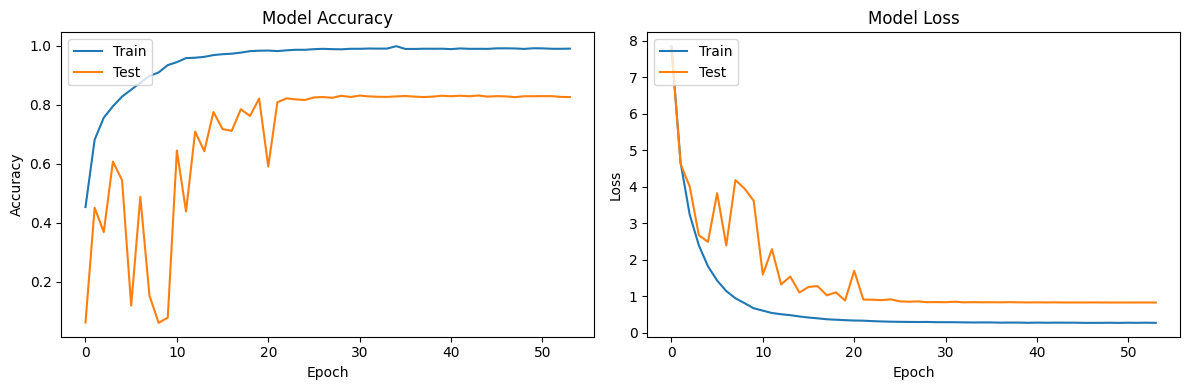

# Load the model

In [ ]:

# Load the trained model
# model = load_model('/content/model_weights.h5')  # Replace with the path to your trained model file


# Testing

In [ ]:

def cosine_similarity(vector1, vector2):
    """
    Calculate the cosine similarity between two vectors.

    Parameters:
    - vector1: The first vector (NumPy array).
    - vector2: The second vector (NumPy array).

    Returns:
    - similarity: The cosine similarity between the two vectors.
    """
    # Ensure that the vectors are 1D arrays
    vector1 = vector1.flatten()
    vector2 = vector2.flatten()

    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)

    # Handle cases where the denominator is close to zero
    if norm_vector1 == 0 or norm_vector2 == 0:
        return 0.0  # Cosine similarity is undefined

    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 260, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 200, 260, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 200, 260, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 200, 260, 3)          0         ['normalization[0][0]'] 

# Evaluation

In [ ]:

# Load test.json to get image names and labels
with open('/content/unzipped_images/human_activity_retrieval_dataset/test_image_info.json', 'r') as json_file:
    test_data = json.load(json_file)

# Directory path to the gallery images
gallery_dir = '/content/unzipped_images/human_activity_retrieval_dataset/gallery'  # Adjust the path as needed

# Directory path to the query images
query_dir = '/content/unzipped_images/human_activity_retrieval_dataset/query_images'  # Adjust the path as needed

# Initialize lists to store labels and image filenames
gallery_labels = []
gallery_image_filenames = []
query_labels = []
query_image_filenames = []

# Precompute and store predictions for gallery images
gallery_predictions = []

for filename in os.listdir(gallery_dir):
    if filename in test_data:
        label = test_data[filename]
        gallery_labels.append(label)
        gallery_image_filenames.append(filename)

        # Load and preprocess the gallery image
        gallery_image_path = os.path.join(gallery_dir, filename)
        gallery_image = cv2.imread(gallery_image_path)
        gallery_image = cv2.resize(gallery_image, (260, 200))  # Adjust target size
        gallery_image = gallery_image / 255.0  # Normalize to [0, 1] range (if necessary)

        # Predict class probabilities for the gallery image
        gallery_probs = model.predict(np.expand_dims(gallery_image, axis=0))
        gallery_predictions.append(gallery_probs)

# Process query images and associate labels
for filename in os.listdir(query_dir):
    if filename in test_data:
        label = test_data[filename]
        query_labels.append(label)
        query_image_filenames.append(filename)

print("Gallery images: ", len(gallery_image_filenames))
print("Query images: ", len(query_image_filenames))



In [ ]:
# Initialize lists to store evaluation metrics
map_values = []
mean_rank_values = []

# Initialize query_similarity_scores to store similarity scores for each query
query_similarity_scores = []

# Loop through each query image
for query_index, query_image_filename in enumerate(query_image_filenames):
    # Load and preprocess the query image
    query_image_path = os.path.join(query_dir, query_image_filename)
    query_image = cv2.imread(query_image_path)
    query_image = cv2.resize(query_image, (260, 200))  # Adjust target size
    query_image = query_image / 255.0  # Normalize to [0, 1] range

    print(query_image.shape)
    # Predict the class probabilities for the query image using the trained model
    query_probs = model.predict(np.expand_dims(query_image, axis=0))

    # Access precomputed gallery predictions
    gallery_probs_list = gallery_predictions

    # Calculate similarity scores between query and gallery images using precomputed predictions
    similarity_scores = [cosine_similarity(query_probs, gallery_probs) for gallery_probs in gallery_probs_list]

    # Append the similarity scores for the current query image to the list
    query_similarity_scores.append(similarity_scores)

    # Sort gallery images by similarity score (higher is better)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_labels = [gallery_labels[i] for i in sorted_indices]

    # Calculate Average Precision (AP) for the current query
    relevant_indices = [i for i, label in enumerate(sorted_labels) if label == query_labels[query_index]]

    if len(relevant_indices) > 0:
        true_labels = [1 if i in relevant_indices else 0 for i in range(len(sorted_labels))]
        sorted_similarity_scores = [similarity_scores[i] for i in sorted_indices]
        ap = average_precision_score(true_labels, sorted_similarity_scores)
    else:
        ap = 0.0

    # Calculate Mean Rank for the current query
    mean_rank = sorted_labels.index(query_labels[query_index]) + 1

    # Append metrics to the lists
    map_values.append(ap)
    mean_rank_values.append(mean_rank)

(200, 260, 3)
1/1 [==============================] - 0s 36ms/step
(200, 260, 3)
1/1 [==============================] - 0s 35ms/step
(200, 260, 3)
1/1 [==============================] - 0s 38ms/step
(200, 260, 3)
1/1 [==============================] - 0s 34ms/step
(200, 260, 3)
1/1 [==============================] - 0s 36ms/step
(200, 260, 3)
1/1 [==============================] - 0s 35ms/step
(200, 260, 3)
1/1 [==============================] - 0s 33ms/step
(200, 260, 3)
1/1 [==============================] - 0s 32ms/step
(200, 260, 3)
1/1 [==============================] - 0s 32ms/step
(200, 260, 3)
1/1 [==============================] - 0s 43ms/step
(200, 260, 3)
1/1 [==============================] - 0s 37ms/step
(200, 260, 3)
1/1 [==============================] - 0s 44ms/step
(200, 260, 3)
1/1 [==============================] - 0s 34ms/step
(200, 260, 3)
1/1 [==============================] - 0s 32ms/step
(200, 260, 3)
1/1 [==============================] - 0s 33ms/step
(200, 260,

In [ ]:
# Calculate and print Mean Average Precision (mAP)
mAP = np.mean(map_values)
print(f"Mean Average Precision (mAP): {mAP}")

# Calculate and print Mean Rank
mean_rank = np.mean(mean_rank_values)
print(f"Mean Rank: {mean_rank}")

# Calculate mAP at different values of K (e.g., K = 1, 10, 50)
k_values = [1, 10, 50]
# Calculate Mean Average Precision (mAP) at specified values of K
map_at_k_values = []

for k in k_values:
    # Calculate mAP at K for each query
    ap_at_k_values = []
    for query_index, query_similarity_score in enumerate(query_similarity_scores):
        top_k_indices = np.argsort(query_similarity_score)[::-1][:k]
        top_k_labels = [gallery_labels[i] for i in top_k_indices]

        # Calculate Average Precision (AP) at K for the current query
        relevant_indices = [i for i, label in enumerate(top_k_labels) if label == query_labels[query_index]]

        if len(relevant_indices) > 0:
            true_labels = [1 if i in relevant_indices else 0 for i in range(len(top_k_labels))]
            sorted_similarity_scores = [query_similarity_score[i] for i in top_k_indices]  # Sort similarity scores in descending order
            ap_at_k = average_precision_score(true_labels, sorted_similarity_scores)  # Corrected
        else:
            ap_at_k = 0.0  # Set AP to 0 if there are no relevant items in the top K

        ap_at_k_values.append(ap_at_k)

    # Calculate Mean Average Precision (mAP) at K across all queries
    map_at_k = np.mean(ap_at_k_values)
    map_at_k_values.append(map_at_k)

# mAP at specified K values and Mean Rank values
print(f"Mean Average Precision (mAP) at K={k_values}: {map_at_k_values}")
print(f"Mean Rank values: {mean_rank_values}")

Mean Average Precision (mAP): 0.6434134238172177
Mean Rank: 6.426666666666667
Mean Average Precision (mAP) at K=[1, 10, 50]: [0.6866666666666666, 0.7560603783488705, 0.7456527644696674]
Mean Rank values: [1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 4, 61, 1, 1, 1, 1, 12, 1, 3, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 1, 1, 39, 2, 26, 1, 1, 44, 1, 1, 1, 1, 1, 85, 1, 8, 1, 1, 2, 2, 1, 42, 3, 2, 1, 1, 1, 2, 1, 2, 1, 12, 1, 1, 37, 45, 1, 1, 1, 11, 2, 1, 1, 2, 1, 1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 83, 40, 59, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 37, 1, 1, 1, 55, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 44, 1, 1, 1, 1, 39, 1, 1, 1, 1, 5, 1]


# Display the results

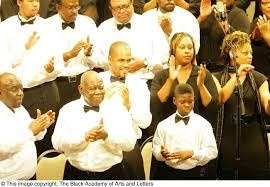

Query Image: Label=clapping
1/1 [==============================] - 0s 29ms/step


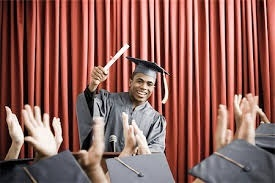

Gallery Image 1: Label=clapping, Similarity Score=1.00


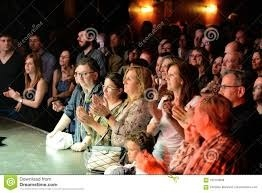

Gallery Image 2: Label=clapping, Similarity Score=1.00


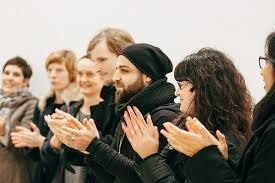

Gallery Image 3: Label=clapping, Similarity Score=1.00


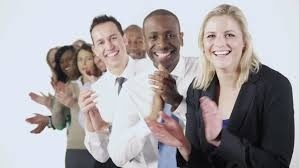

Gallery Image 4: Label=clapping, Similarity Score=1.00


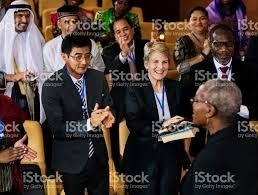

Gallery Image 5: Label=clapping, Similarity Score=1.00


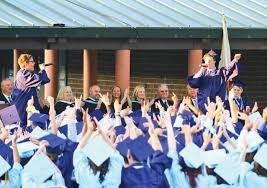

Gallery Image 6: Label=clapping, Similarity Score=1.00


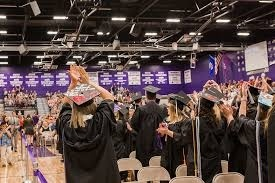

Gallery Image 7: Label=clapping, Similarity Score=1.00


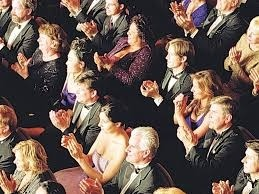

Gallery Image 8: Label=clapping, Similarity Score=1.00


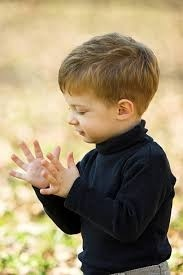

Gallery Image 9: Label=clapping, Similarity Score=1.00


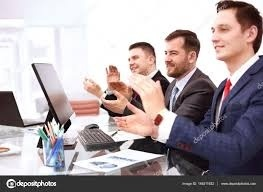

Gallery Image 10: Label=clapping, Similarity Score=1.00


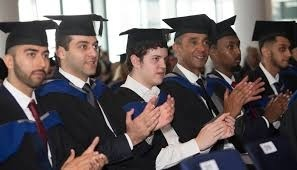

Gallery Image 11: Label=clapping, Similarity Score=1.00


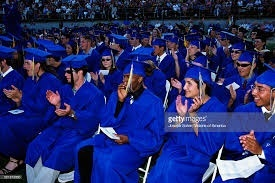

Gallery Image 12: Label=clapping, Similarity Score=1.00


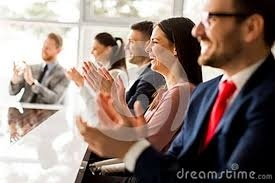

Gallery Image 13: Label=clapping, Similarity Score=1.00


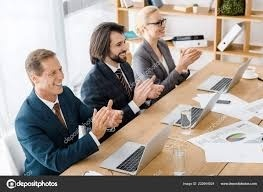

Gallery Image 14: Label=clapping, Similarity Score=1.00


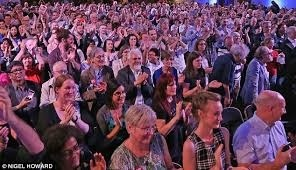

Gallery Image 15: Label=clapping, Similarity Score=1.00


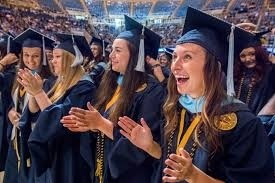

Gallery Image 16: Label=clapping, Similarity Score=1.00


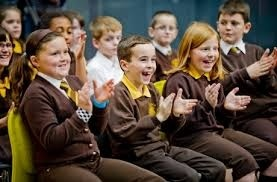

Gallery Image 17: Label=clapping, Similarity Score=1.00


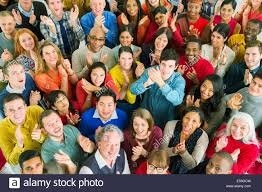

Gallery Image 18: Label=clapping, Similarity Score=1.00


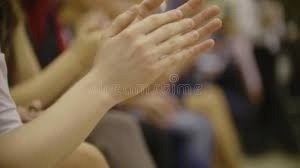

Gallery Image 19: Label=clapping, Similarity Score=1.00


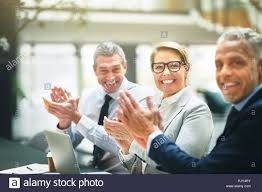

Gallery Image 20: Label=clapping, Similarity Score=1.00


In [ ]:

# Function to calculate similarity score
def calculate_similarity(query_probs, gallery_probs):
    similarity_score = np.dot(query_probs, gallery_probs.T)
    return similarity_score

# Load and preprocess the query image
query_image_filename = 'Image_9083.jpg'
query_image_path = os.path.join(query_dir, query_image_filename)
query_image = cv2.imread(query_image_path)

# Display the query image
cv2_imshow(query_image)
print(f"Query Image: Label={test_data[query_image_filename]}")

query_image = cv2.resize(query_image, (260, 200))  # Adjust target size
query_image = query_image / 255.0  # Normalize to [0, 1] range

# Predict class probabilities for the query image
query_probs = model.predict(np.expand_dims(query_image, axis=0))

# Initialize lists to store relevant images and their similarity scores
relevant_images = []
similarity_scores = []

# Loop through each gallery image and calculate similarity scores
for gallery_probs in gallery_predictions:
    # Calculate the similarity score
    similarity_score = cosine_similarity(query_probs, gallery_probs)
    similarity_scores.append(similarity_score)

# Sort gallery images by similarity score (higher is better)
sorted_indices = np.argsort(similarity_scores)[::-1]
sorted_labels = [gallery_labels[i] for i in sorted_indices]

# Display the top 20 relevant images and their information
top_k = 20
for i in range(top_k):
    gallery_image_filename = gallery_image_filenames[sorted_indices[i]]
    similarity_score = similarity_scores[sorted_indices[i]]
    gallery_label = sorted_labels[i]

    # Load and display the gallery image
    gallery_image_path = os.path.join(gallery_dir, gallery_image_filename)
    gallery_image = cv2.imread(gallery_image_path)

    # Display the gallery image
    cv2_imshow(gallery_image)
    print(f"Gallery Image {i+1}: Label={gallery_label}, Similarity Score={similarity_score:.2f}")
